<a href="https://colab.research.google.com/github/rostro36/Partisan-Responses/blob/master/08_Coref%26Knowledge_Graph_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Partisan-Responses-master')

Install all requirements.

In [ ]:
!pip install torchtext
!pip install neuralcoref allennlp hnswlib allennlp-models torch==1.5.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install spacy==2.1.0
!python -m spacy download en
!pip install wandb

Import everything

In [ ]:
import torch
import neuralcoref
import spacy
import re
import pickle
import pandas as pd
import gc
import utils
from Answer import Answer
from Speech import Speech
from KnowledgeGraph import KnowledgeGraph
import nltk

Setup everything for coref

Or download them from [here](https://drive.google.com/file/d/1FgzkMotUENDZchraXDQesr1kc4tu12pc/view?usp=sharing).

In [30]:
nlp = spacy.load('en')
neuralcoref.add_to_pipe(nlp)

identifier='answers'
last_check=0
step_size=1000

def load_pickles(identifier, checkpoint):
  if os.path.exists("df"+identifier+str(checkpoint)+".pickle"):
    df = pd.read_pickle("df"+identifier+str(checkpoint)+".pickle")
  return df

def dump_pickles(identifier, checkpoint, df):
  df.to_pickle("df"+identifier+str(checkpoint)+".pickle")
  gc.collect()
  return 

def make_corefs(content):
    content=str(re.sub("\.(?=\s[a-z0-9]|\sI[\W\s])", ",", content))
    doc=nlp(content)
    return doc._.coref_resolved

df = pd.read_pickle("partisan_search_results.pkl")

In [31]:
import numpy as np
questions=[]
parties=[]
speeches=[]
for question in df.keys():
  for party in ['R','D']:
    for speech in df[question][party]:
      questions.append(question)
      parties.append(party)
      speeches.append(speech)
df = pd.DataFrame(np.array([questions,parties,speeches]).transpose(), columns = ['question', 'party','speech'])

In [ ]:
df

Do coref

In [32]:
for i in range(last_check+1,int(df.shape[0]/step_size)):
  print(i)
  for j in range(step_size):
    df.iloc[step_size*(i-1)+j]['speech']=make_corefs(df.iloc[step_size*(i-1)+j]['speech'])
  dump_pickles(identifier,i,df)
print('done with ordered')
for j in range(df.shape[0]-int(df.shape[0]/step_size)*step_size):
  df.iloc[step_size*int(df.shape[0]/step_size)+j]['speech']=make_corefs(df.iloc[step_size*int(df.shape[0]/step_size)+j]['speech'])
df.to_pickle(identifier+".pkl")

done with ordered


Initialize empty knowledge graphs

In [33]:
import gc
knowledgeGraphs=dict()
for i in range(df.shape[0]):
  question=df.iloc[i,0]
  knowledgeGraphs[question]=KnowledgeGraph(question)

Build knowledge graph

question                          Should abortion be illegal?
party                                                       R
speech      Mr. Speaker. Congress now has an opportunity t...
Name: 0, dtype: object


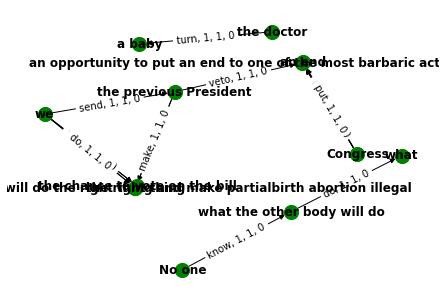

question                          Should abortion be illegal?
party                                                       R
speech      I rise today to express my opposition to both ...
Name: 1, dtype: object


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


question                          Should abortion be illegal?
party                                                       R
speech      I am glad to follow my colleague from Utah, I ...
Name: 2, dtype: object


RuntimeError: ignored

In [34]:
for i in range(df.shape[0]):
  gc.collect()
  question=df.iloc[i,0]
  drawer=False
  triplets=Speech(df.iloc[i]).create_triplet()
  if knowledgeGraphs[question].node_index is None:
    drawer=True
  knowledgeGraphs[question].add_edges(triplets)
  if drawer:
    knowledgeGraphs[question].draw("start"+question[:10])

Draw knowledge graph

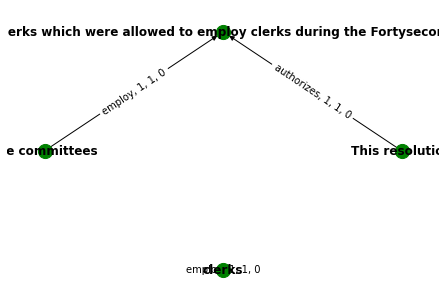

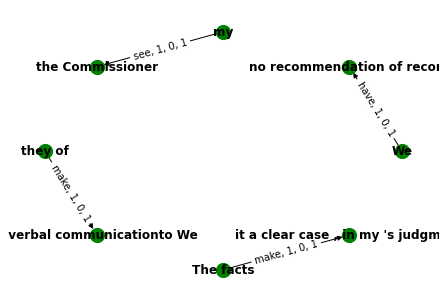

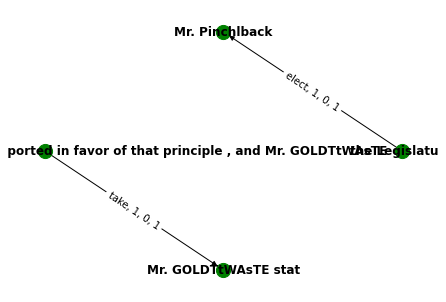

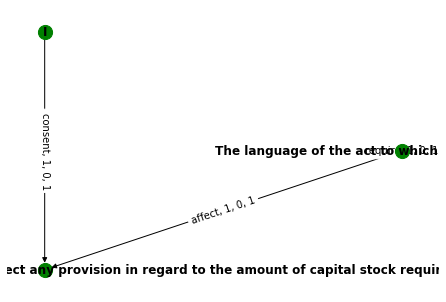

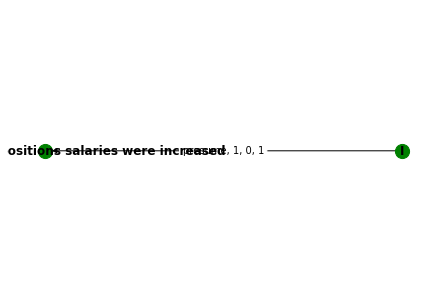

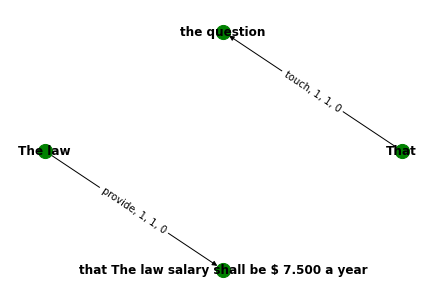

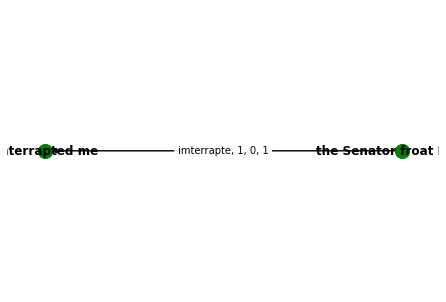

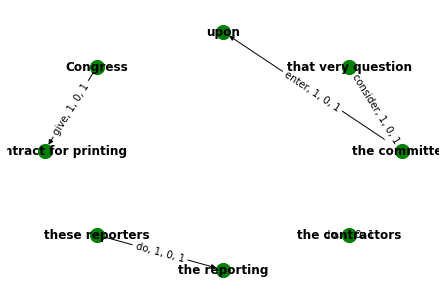

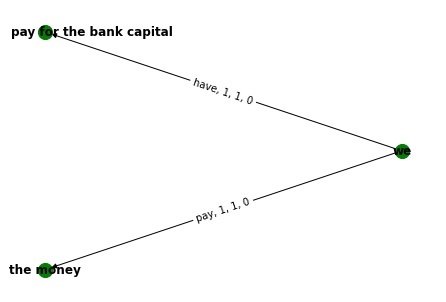

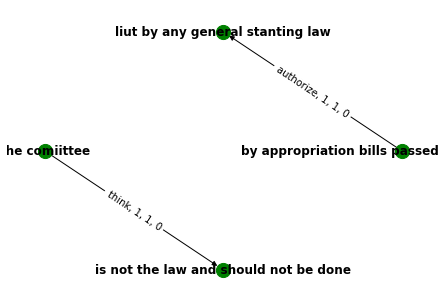

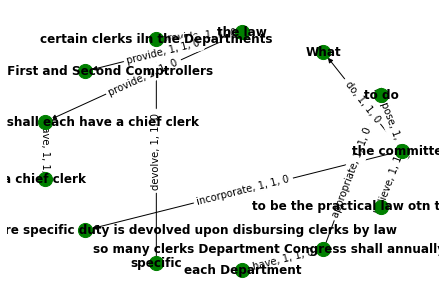

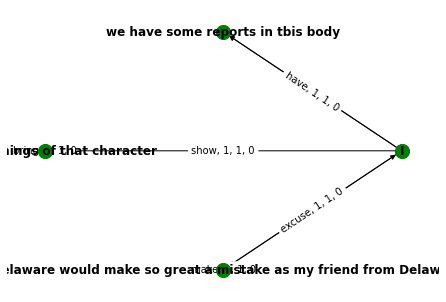

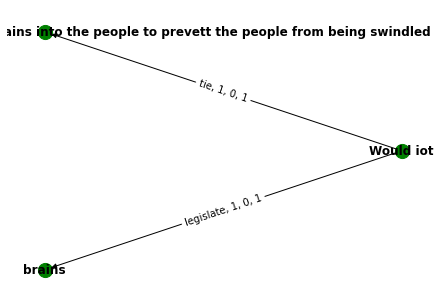

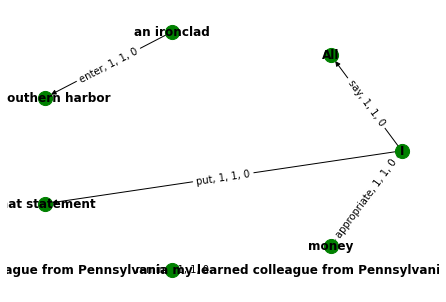

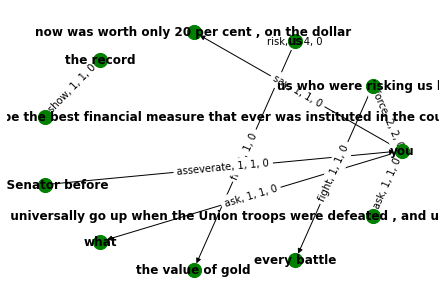

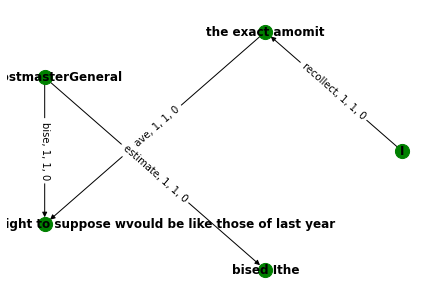

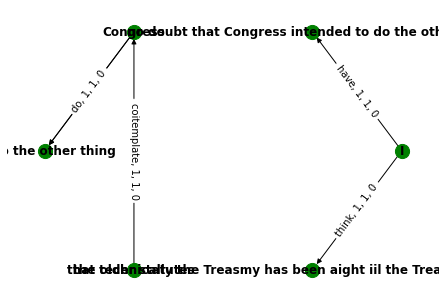

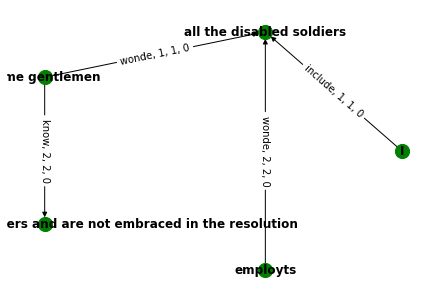

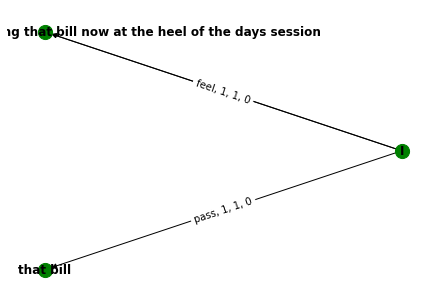

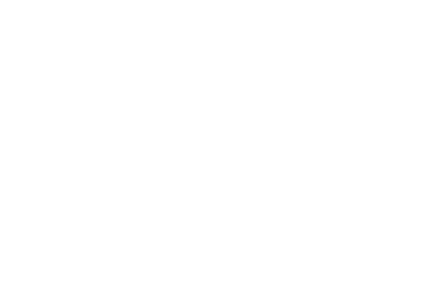

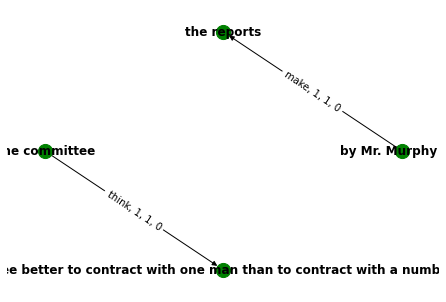

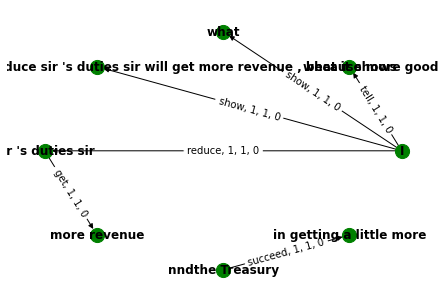

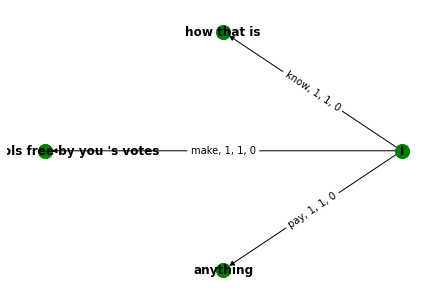

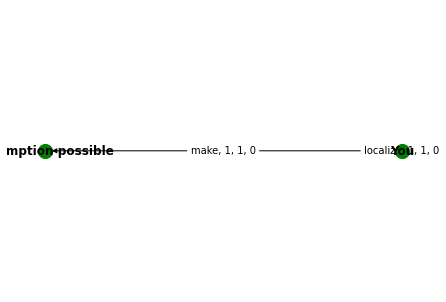

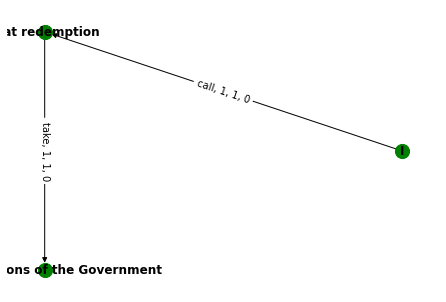

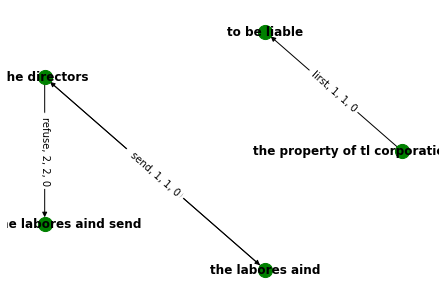

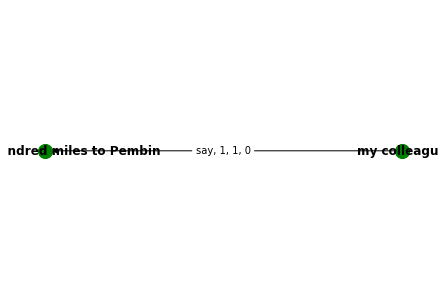

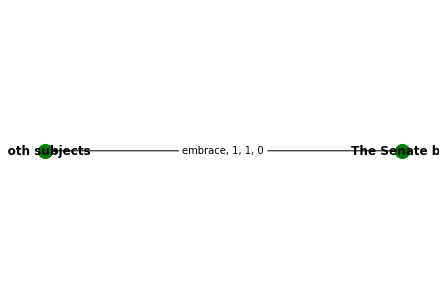

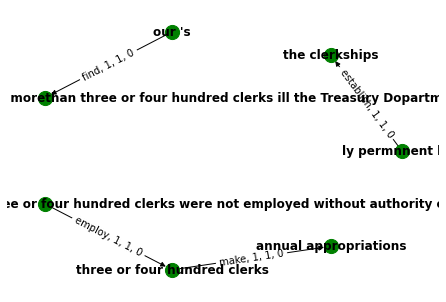

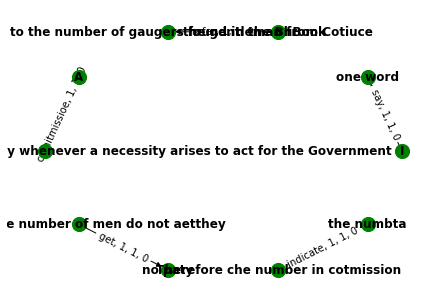

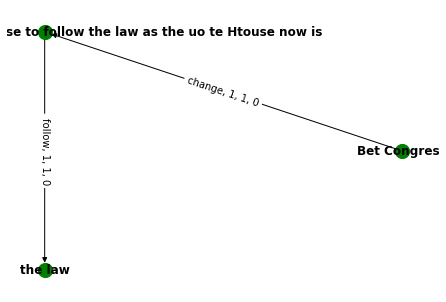

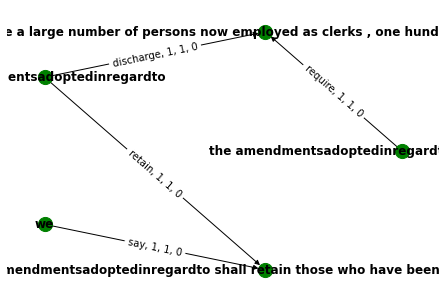

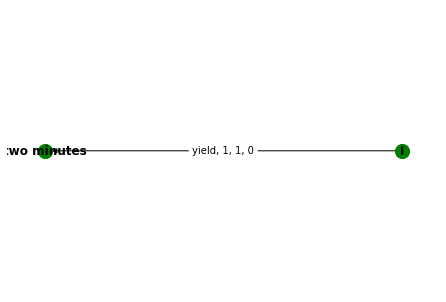

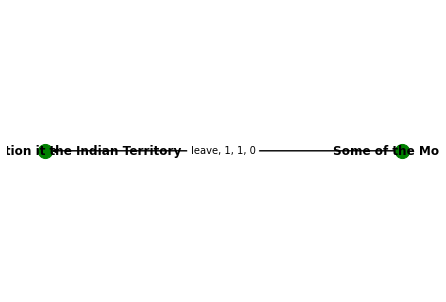

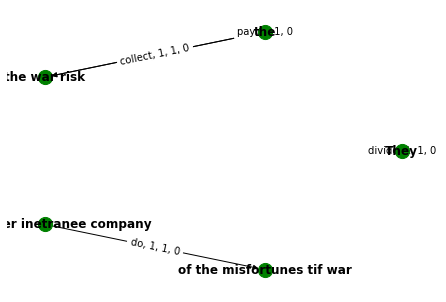

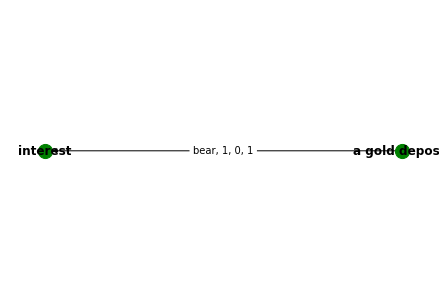

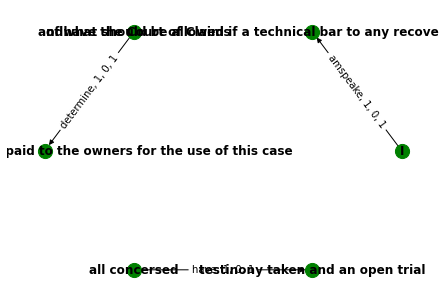

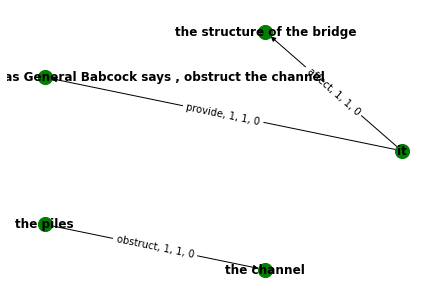

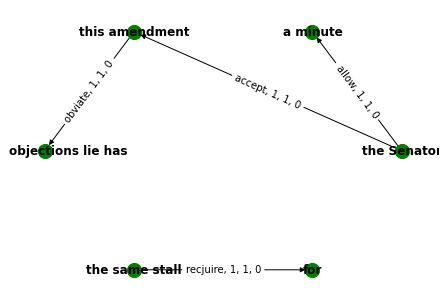

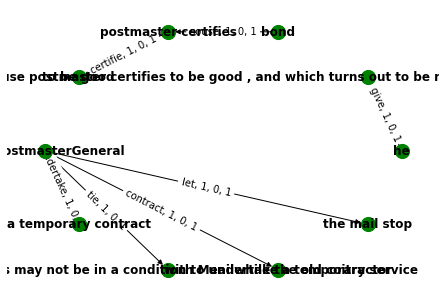

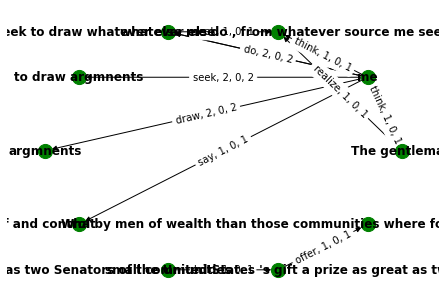

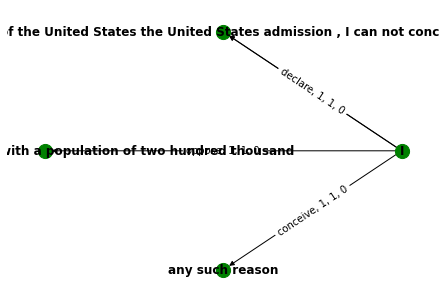

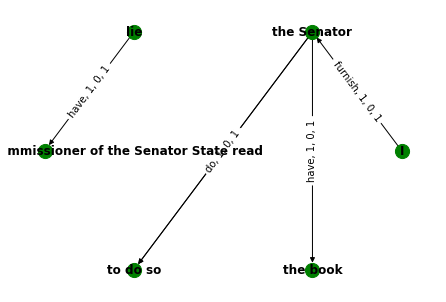

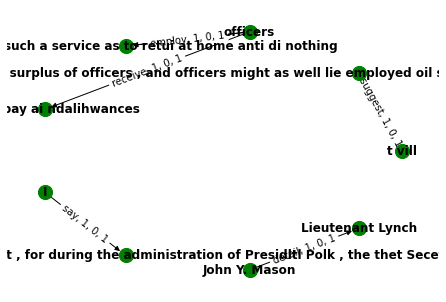

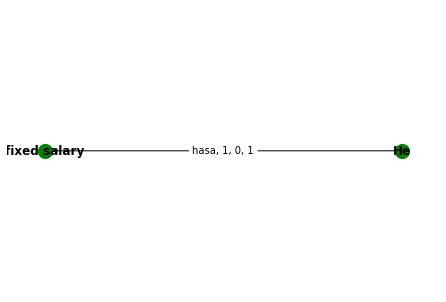

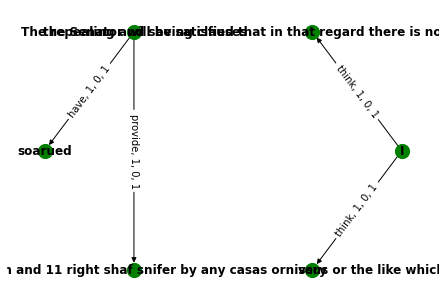

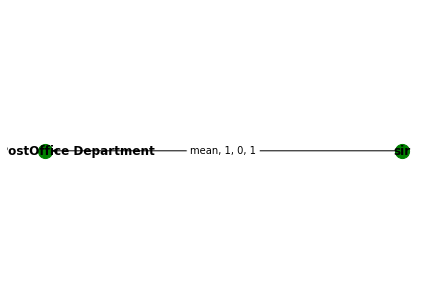

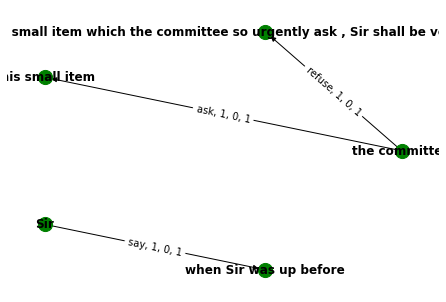

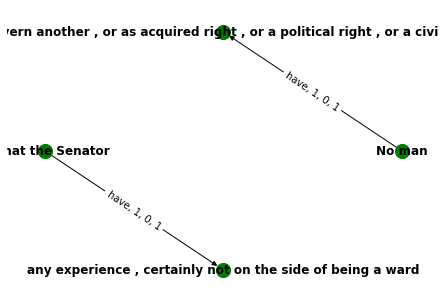

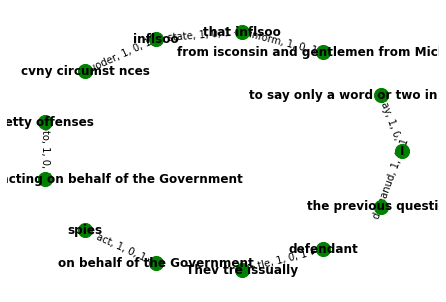

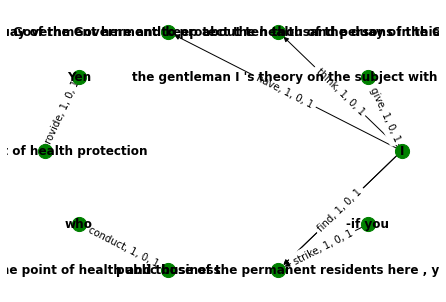

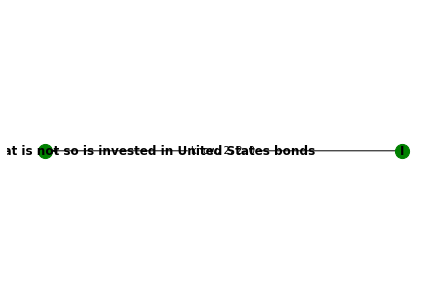

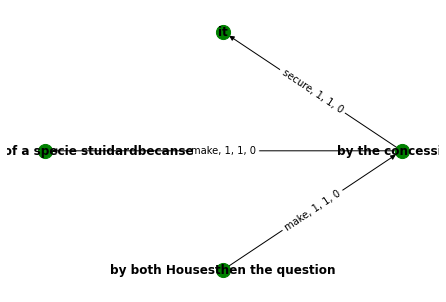

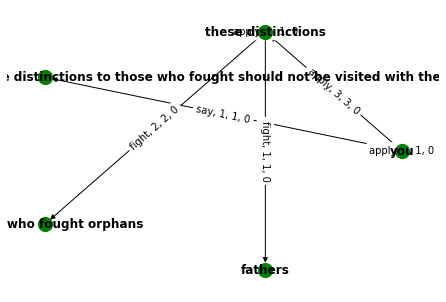

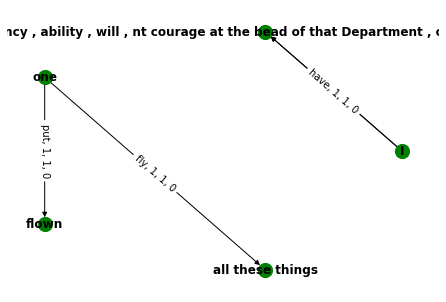

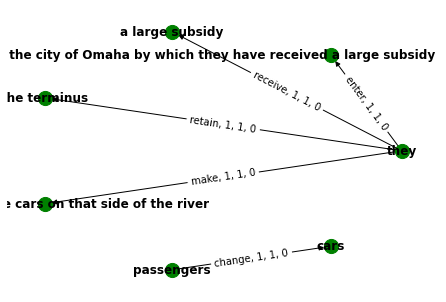

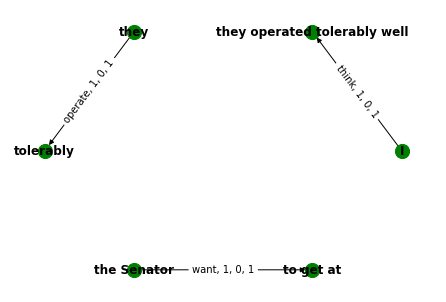

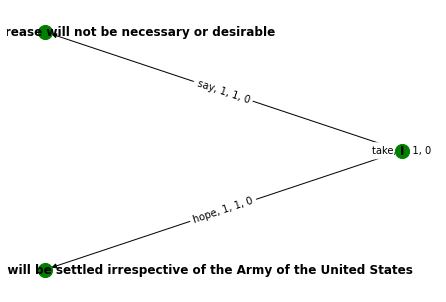

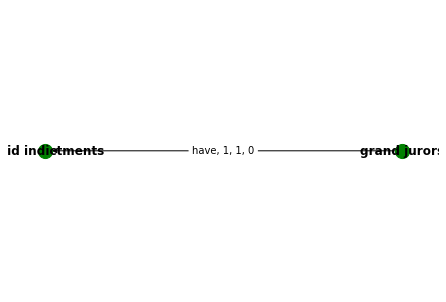

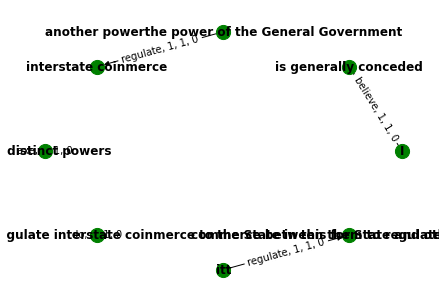

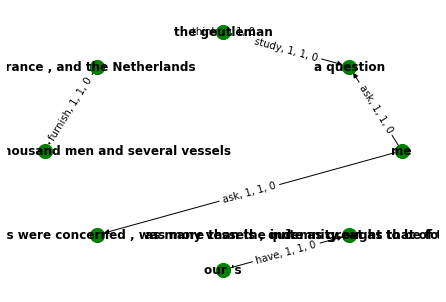

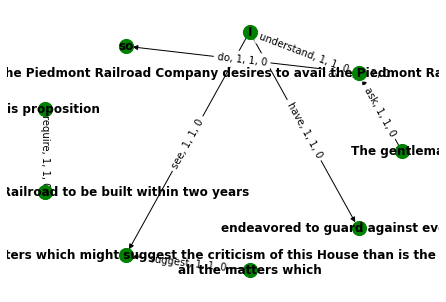

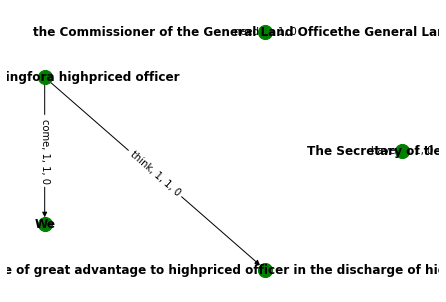

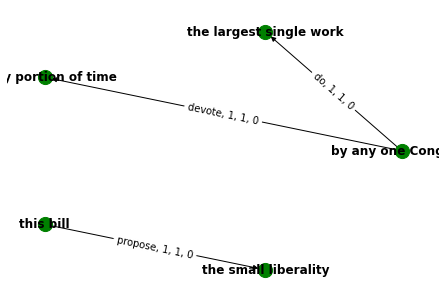

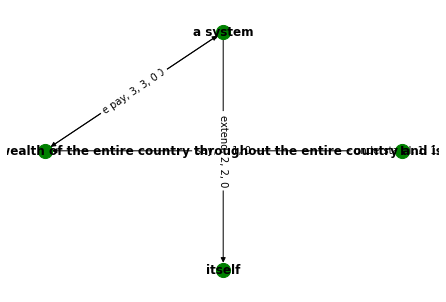

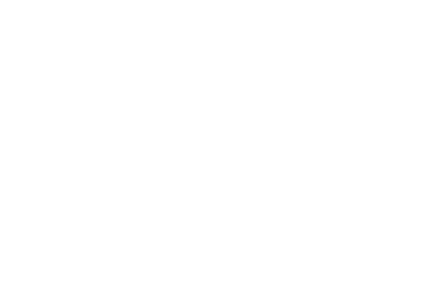

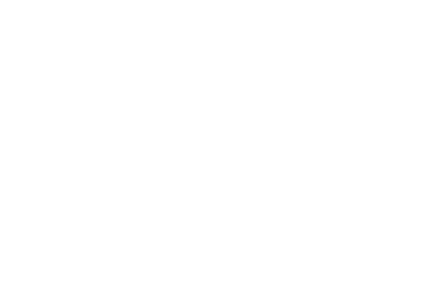

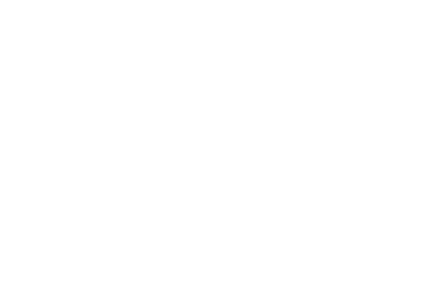

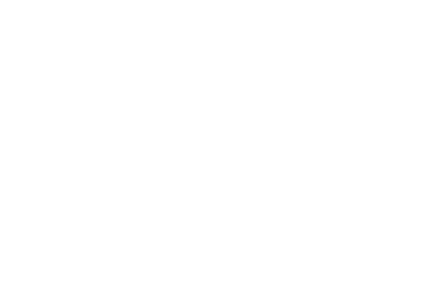

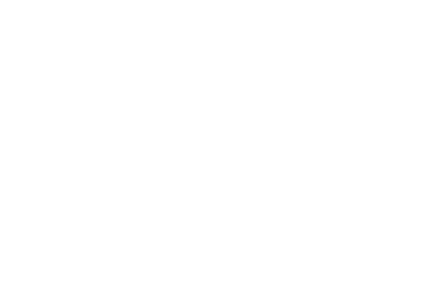

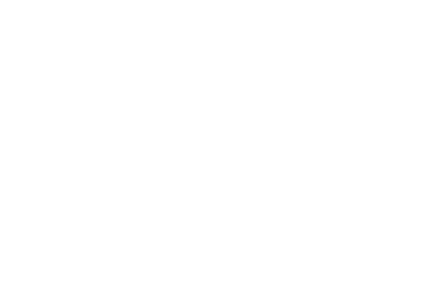

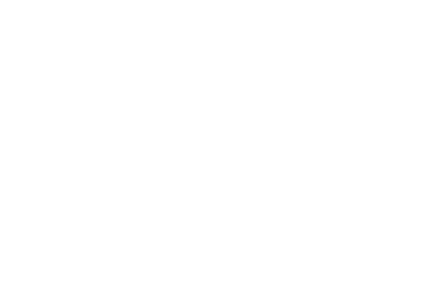

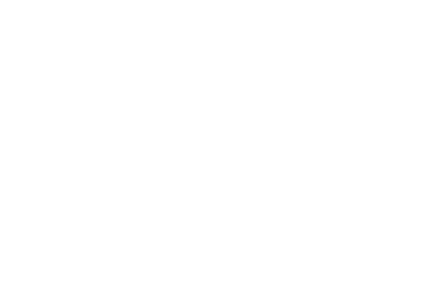

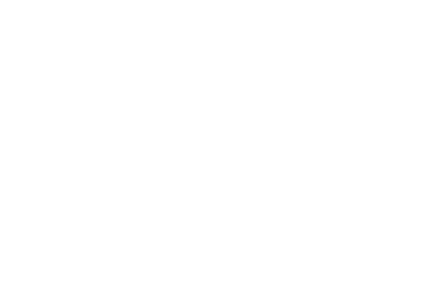

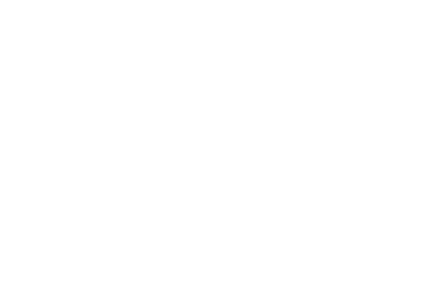

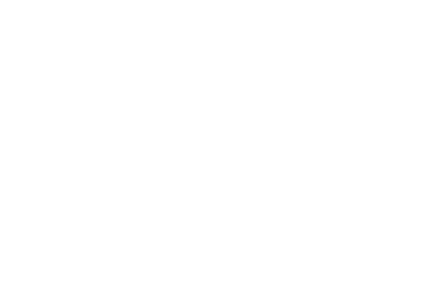

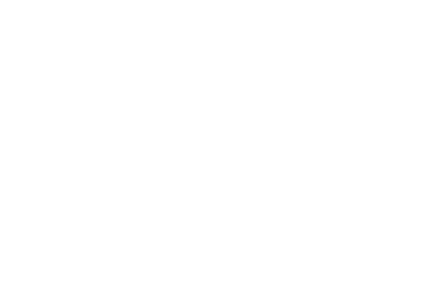

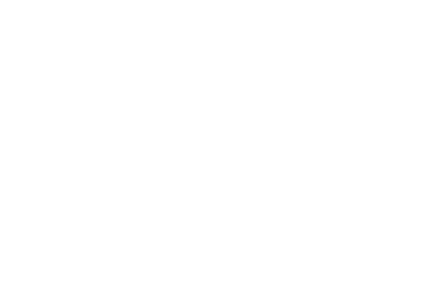

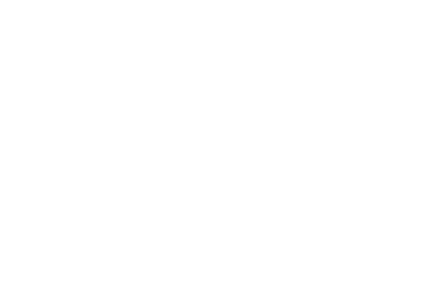

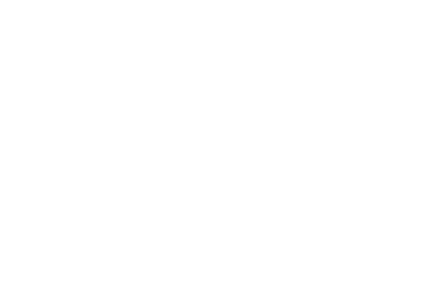

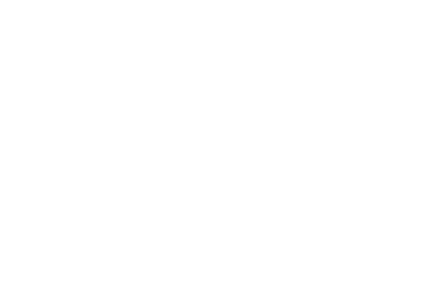

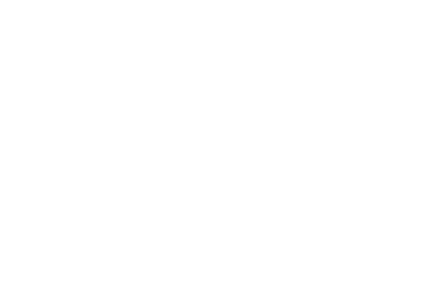

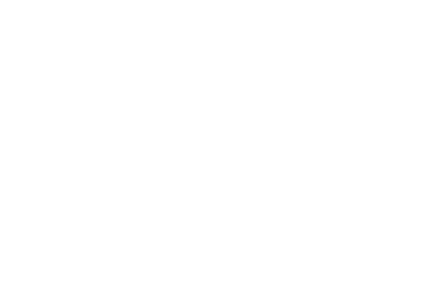

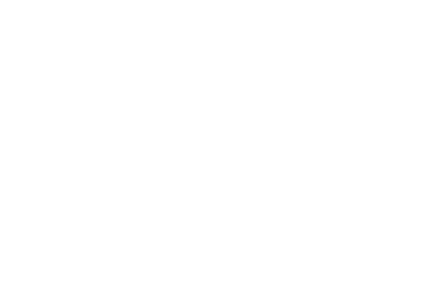

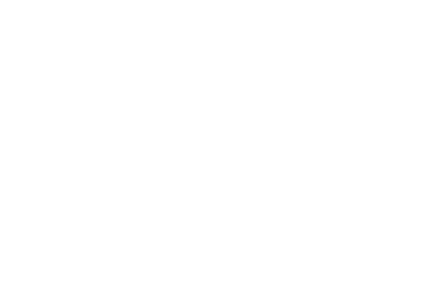

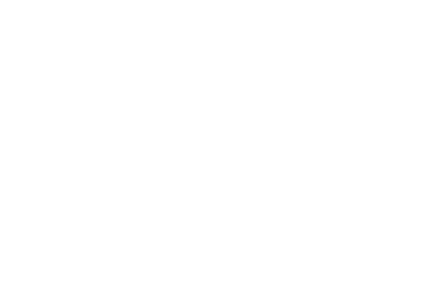

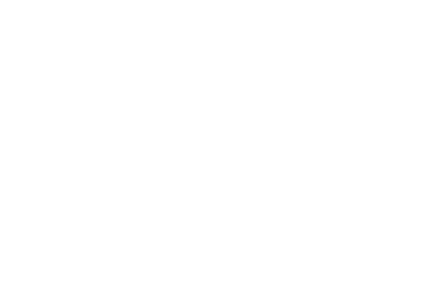

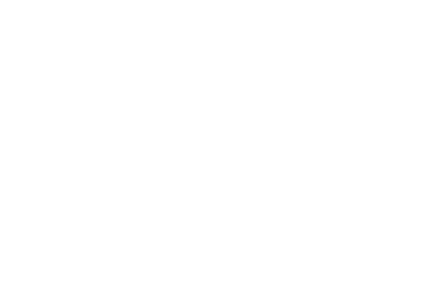

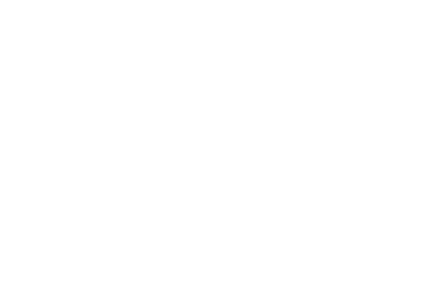

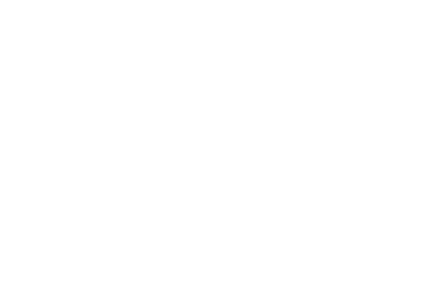

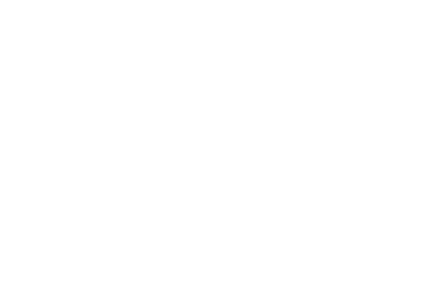

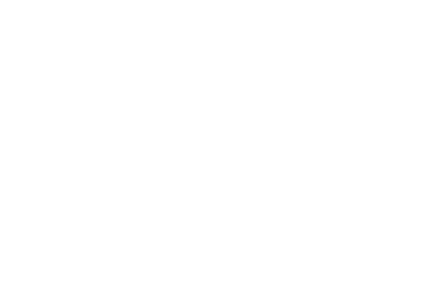

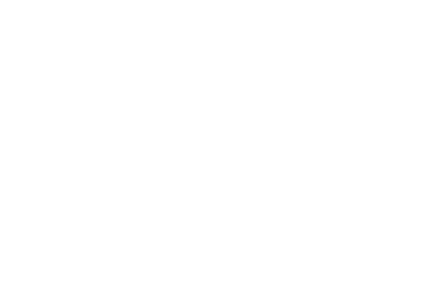

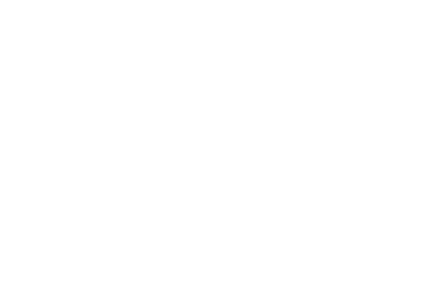

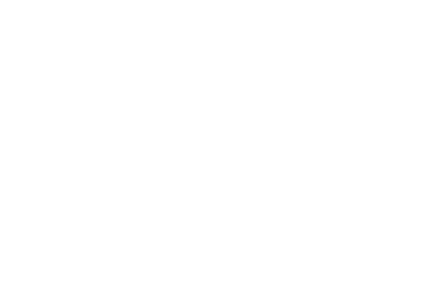

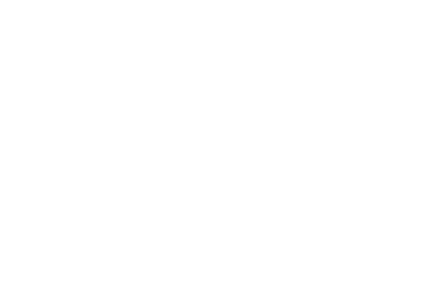

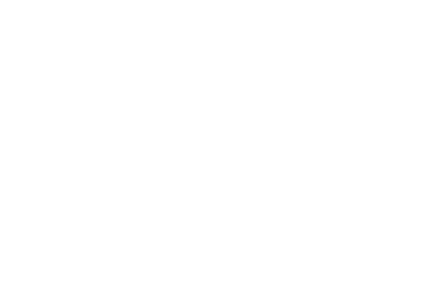

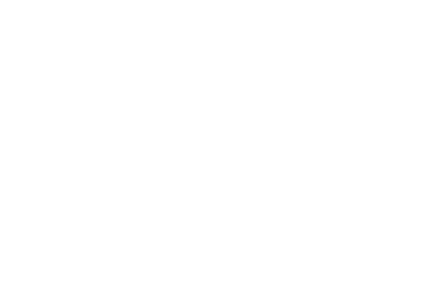

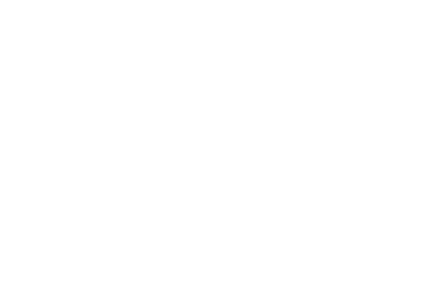

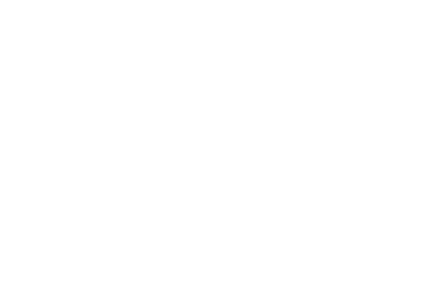

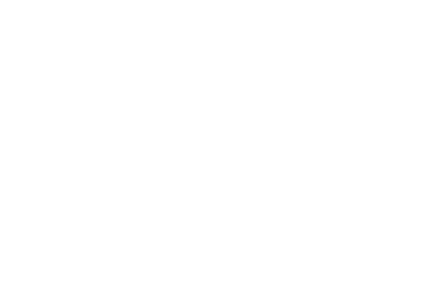

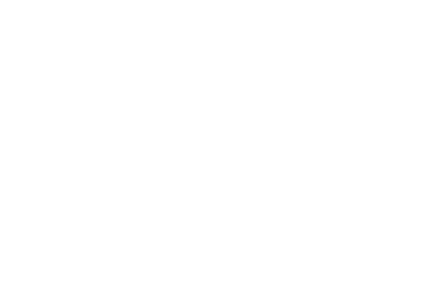

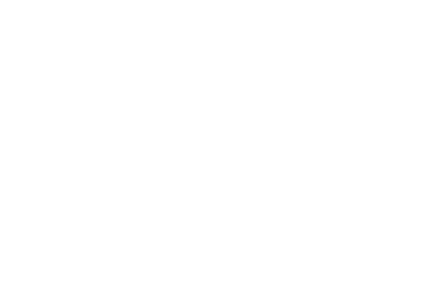

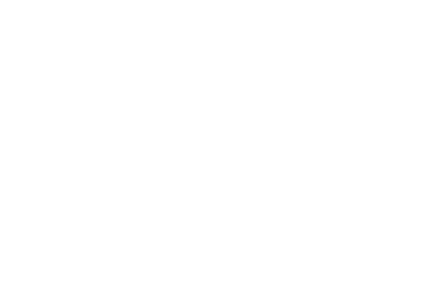

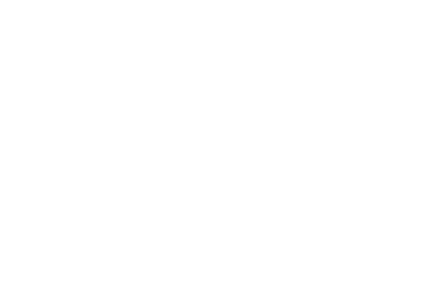

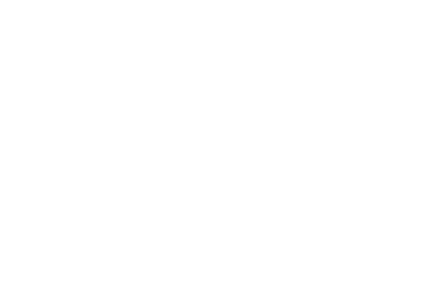

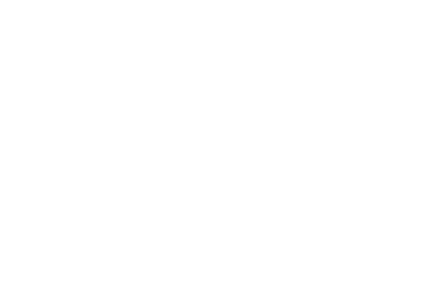

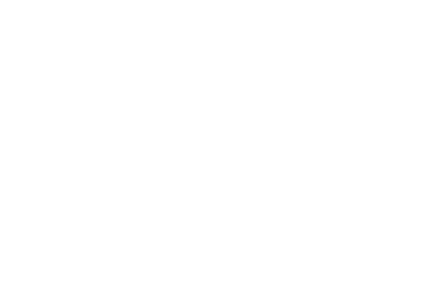

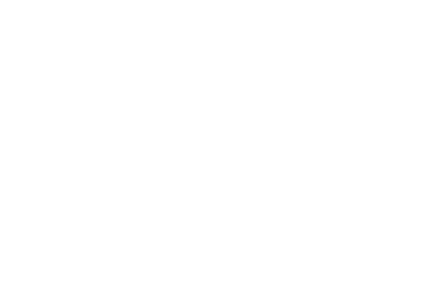

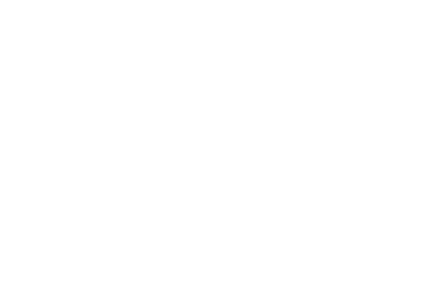

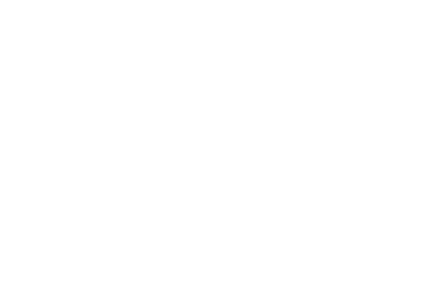

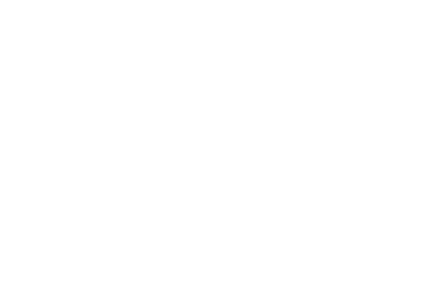

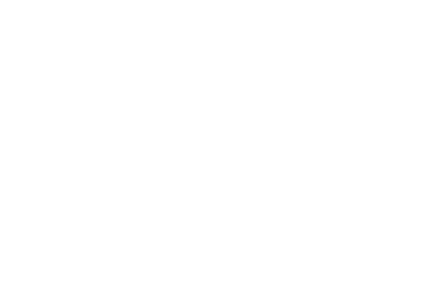

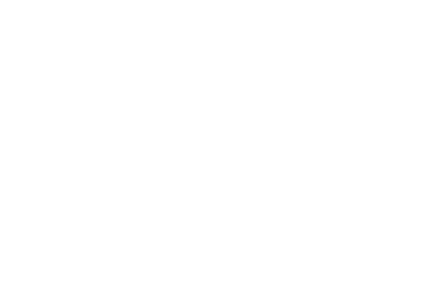

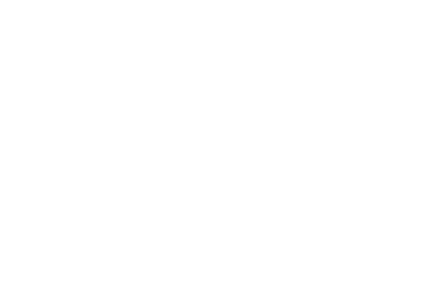

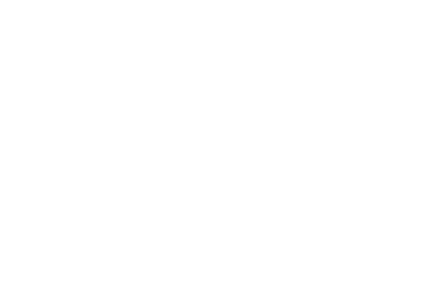

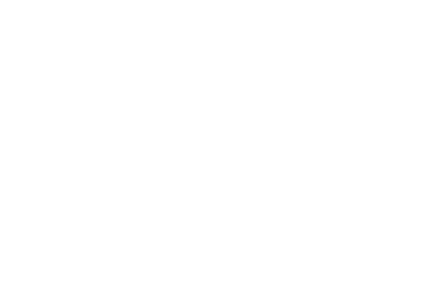

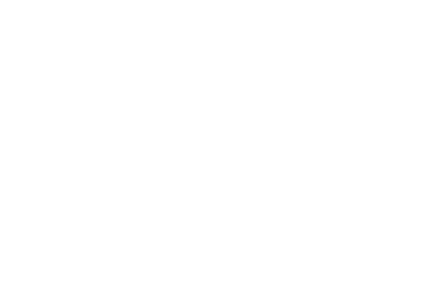

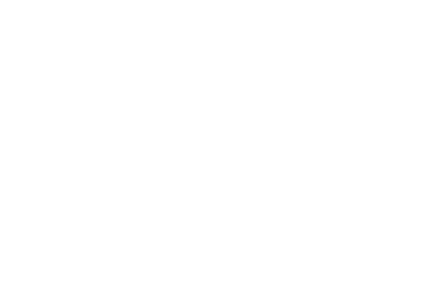

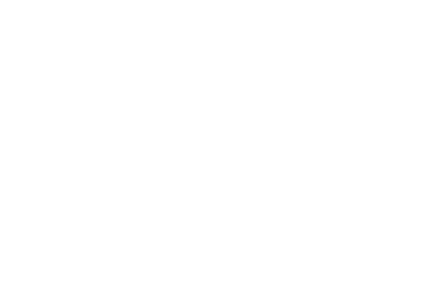

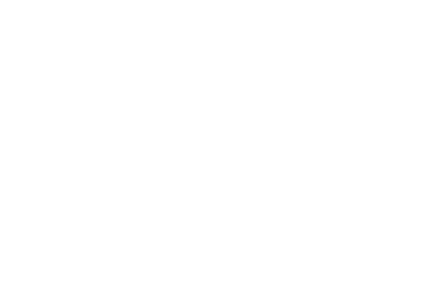

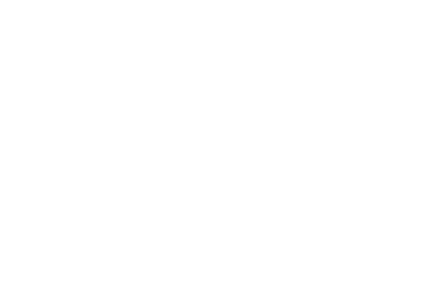

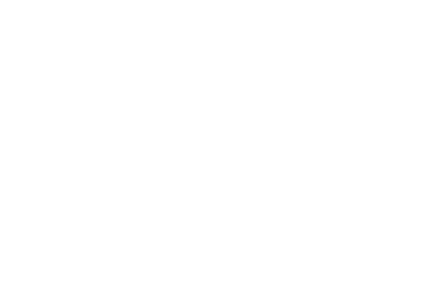

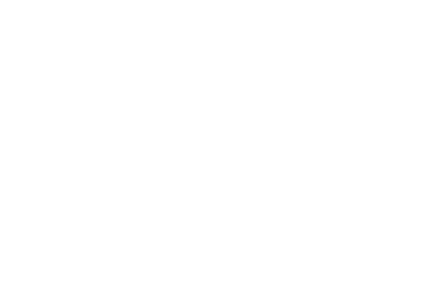

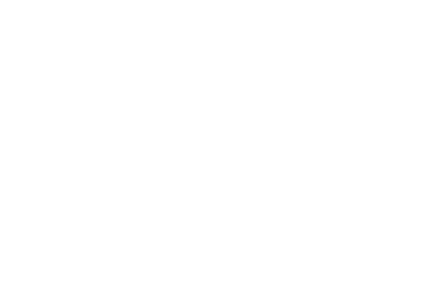

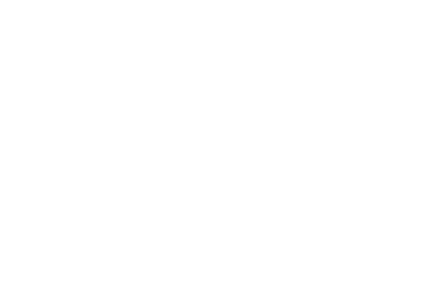

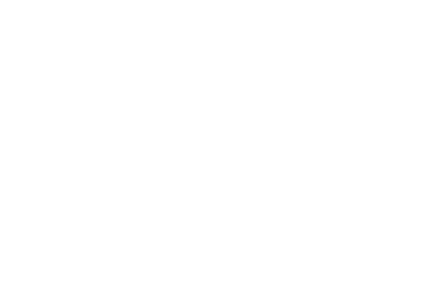

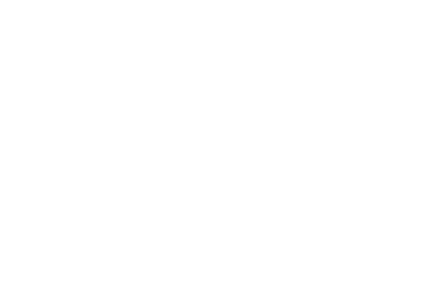

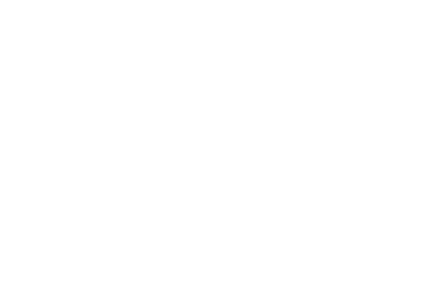

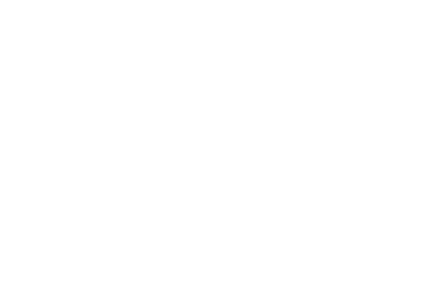

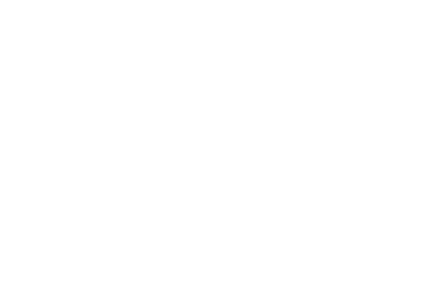

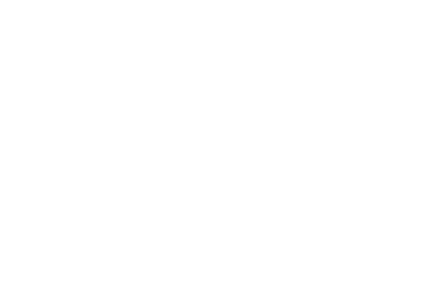

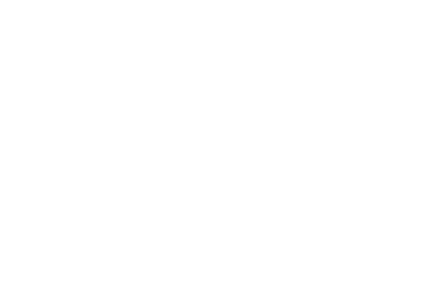

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
for knowledgeGraph in knowledgeGraphs:
  knowledgeGraphs[knowledgeGraph].draw(knowledgeGraph[:10])